# CODE

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt

#je suis l'étudiant qui a bien répondu à une question qui assurait 20 au TP (Pourquoi on multiplie par P(x) dans P(x) *log(P(x)/Q(x)))

In [2]:
# Load MNIST dataset
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
latent_dim = 2 # Latent space dimension

In [3]:
# Encoder
class Encoder(Model):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(512, activation="relu")  # Augmenter le nombre de neurones et ajouter une couche
        self.dense2 = layers.Dense(256, activation="relu")  # Nouvelle couche
        self.mean = layers.Dense(latent_dim)
        self.log_var = layers.Dense(latent_dim)
    def call(self, x):
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)  
        mean = self.mean(x)
        log_var = self.log_var(x)
        return mean, log_var

In [4]:
# Reparameterization trick
def sample_z(mean, log_var):
    epsilon = tf.random.normal(shape=tf.shape(mean))
    return mean + tf.exp(0.5 * log_var) * epsilon

In [5]:
# Decoder
class Decoder(Model):
    def __init__(self):
        super(Decoder, self).__init__()
        self.dense1 = layers.Dense(256, activation="relu")  # Augmenter le nombre de neurones et ajouter une couche
        self.dense2 = layers.Dense(512, activation="relu") # Nouvelle couche
        self.dense3 = layers.Dense(28 * 28, activation="sigmoid") # Ajouter une nouvelle couche
        self.reshape = layers.Reshape((28, 28, 1))
    def call(self, z):
        z = self.dense1(z)
        z = self.dense2(z)
        z = self.dense3(z)
        return self.reshape(z)

In [6]:
# VAE
class VAE(Model):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    def call(self, x):
        mean, log_var = self.encoder(x)
        z = sample_z(mean, log_var)
        reconstruction = self.decoder(z)
        return reconstruction, mean, log_var

encoder = Encoder(latent_dim)
decoder = Decoder()
vae = VAE(encoder, decoder)

In [7]:
# Loss Function
def vae_loss(x, reconstruction, mean, log_var):
    reconstruction_loss = tf.reduce_mean(
        tf.keras.losses.binary_crossentropy(x, reconstruction)
    )
    reconstruction_loss *= 28 * 28
    kl_divergence = -0.5 * tf.reduce_sum(1 + log_var - tf.square(mean) - tf.exp(log_var))
    kl_divergence *= 0.01
    return reconstruction_loss + kl_divergence

In [8]:
# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# Training Loop
@tf.function
def train_step(x):
    with tf.GradientTape() as tape:
        reconstruction, mean, log_var = vae(x)
        loss = vae_loss(x, reconstruction, mean, log_var)
    gradients = tape.gradient(loss, vae.trainable_variables)
    optimizer.apply_gradients(zip(gradients, vae.trainable_variables))
    return loss

In [9]:
# Training
epochs = 20
batch_size = 128
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(batch_size)
for epoch in range(epochs):
    for step, x_batch in enumerate(train_dataset):
        loss = train_step(x_batch)
    print(f"Epoch {epoch + 1}, Loss: {loss.numpy()}")

Epoch 1, Loss: 166.74464416503906
Epoch 2, Loss: 156.833251953125
Epoch 3, Loss: 160.60592651367188
Epoch 4, Loss: 149.98464965820312
Epoch 5, Loss: 143.4273223876953
Epoch 6, Loss: 142.32350158691406
Epoch 7, Loss: 149.3690643310547
Epoch 8, Loss: 142.71728515625
Epoch 9, Loss: 147.6622772216797
Epoch 10, Loss: 144.7505645751953
Epoch 11, Loss: 154.5083465576172
Epoch 12, Loss: 143.2771453857422
Epoch 13, Loss: 136.87815856933594
Epoch 14, Loss: 150.4200897216797
Epoch 15, Loss: 144.36026000976562
Epoch 16, Loss: 136.2488555908203
Epoch 17, Loss: 145.62152099609375
Epoch 18, Loss: 147.13433837890625
Epoch 19, Loss: 131.8181610107422
Epoch 20, Loss: 139.1200714111328


## test "normal" le decodeur prend comme entrée la sortie de l'encodeur

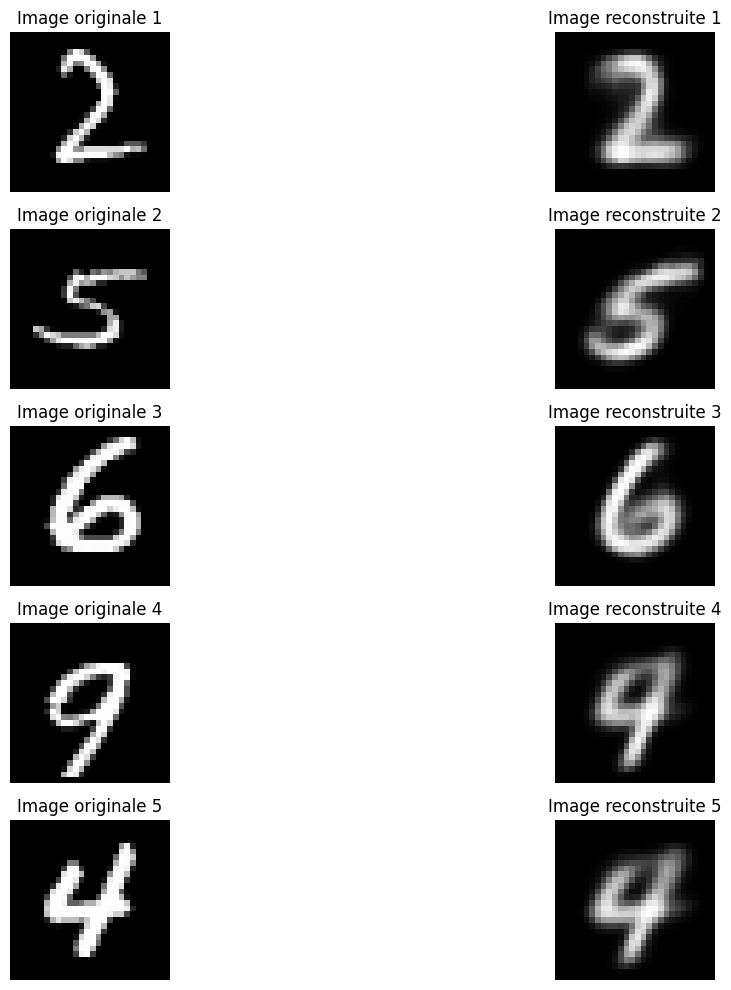

In [19]:
# 1. Définir le nombre d'images à afficher
num_images = 5

# 2. Choisir des images aléatoires à partir de x_test
test_indices = np.random.randint(0, len(x_test), num_images)
test_images = x_test[test_indices]

# 3. Encoder les images tests
mean, log_var = encoder(tf.expand_dims(test_images, axis=1)) # Ajoute une dimension de batch
z = sample_z(mean, log_var)

# 4. Décoder z pour reconstruire les images
reconstructed_images = decoder(z)

# 5. Visualiser les images originales et les images reconstruites
plt.figure(figsize=(15, 10))  # Ajuster la taille pour que tout rentre

for i in range(num_images):
    # Afficher les images originales
    plt.subplot(num_images, 2, 2 * i + 1)
    plt.imshow(test_images[i].squeeze(), cmap='gray')
    plt.title(f"Image originale {i + 1}")
    plt.axis('off')  # Désactiver les axes

    # Afficher les images reconstruites
    plt.subplot(num_images, 2, 2 * i + 2)
    plt.imshow(reconstructed_images[i].numpy().squeeze(), cmap='gray')
    plt.title(f"Image reconstruite {i + 1}")
    plt.axis('off') # Désactiver les axes

plt.tight_layout()
plt.show()

## test à partir d'une sortie d'encodeur simulée

mean : [[-0.7520405   2.9354253 ]
 [-0.8062132  -0.14497392]
 [-0.0171938   0.21553008]
 [ 1.3536295   0.17274417]
 [ 1.1182655   0.5822519 ]], 
 log_var : [[-0.55704993  0.9663786 ]
 [-0.05287996 -1.9125684 ]
 [ 0.98698616 -0.65583867]
 [-0.7302318  -0.3776669 ]
 [ 0.8892862  -2.368864  ]]


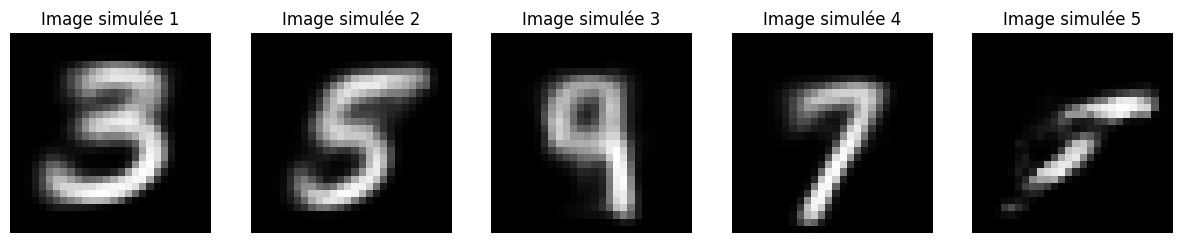

In [18]:
# 1. Définir la dimension de l'espace latent
latent_dim = 2  # Assurez-vous que cela correspond à votre modèle

# 2. Définir le nombre d'images à générer
num_images = 5

# 3. Simuler mean et log_var pour chaque image
mean = tf.random.normal(shape=(num_images, latent_dim), mean=0.0, stddev=1.0)
log_var = tf.random.normal(shape=(num_images, latent_dim), mean=0.0, stddev=1.0)
print(f"mean : {mean}, \n log_var : {log_var}")

# 4. Echantillonner z à l'aide du reparameterization trick
def sample_z(mean, log_var):
    epsilon = tf.random.normal(shape=tf.shape(mean))
    return mean + tf.exp(0.5 * log_var) * epsilon
z = sample_z(mean, log_var)

# 5. Décoder z pour générer les images
reconstructed_images = decoder(z)

# 6. Afficher les images générées
plt.figure(figsize=(15, 5))  # Ajuster la taille de la figure pour afficher toutes les images

for i in range(num_images):
    plt.subplot(1, num_images, i + 1)  # subplot pour chaque image
    plt.imshow(reconstructed_images[i].numpy().squeeze(), cmap='gray')
    plt.title(f"Image simulée {i+1}")
    plt.axis('off')  # Désactiver les axes

plt.show()